In [1]:
import unittest
from time import time, ctime

# CONSTANT
DATA_ROOT = "./data"
DBLP_PATH = DATA_ROOT + "/dblp"
AMAZON_PATH = DATA_ROOT + "/amazon"
FACEBOOK_PATH = DATA_ROOT + "/facebook"
NOTIFY_ENDPOINT = r"https://notify.run/O6EfLmG6Tof1s5DljYB7"


import pandas as pd

from package.model import DiffusionModel
from package.topic import TopicModel
from package.social_graph import SN_Graph
from package.itemset import ItemsetFlyweight, ItemRelation
from package.utils import getItemsPrice, read_items
from package.algorithm import Algorithm
from package.coupon import Coupon

NUM_TOPICS = 5
TOPICS = {
    "Node": {
        "0": [0.9, 0.1, 0.0],
        "1": [0.2, 0.8, 0.0],
        "2": [0.8, 0.2, 0.0],
        "3": [0.2, 0.4, 0.4],
    },
    "Item": {
        "iPhone": [0.7, 0.0, 0.3],
        "AirPods": [0.9, 0.0, 0.1],
        "Galaxy": [0.0, 0.8, 0.2],
    }
}
PRICES = {
    "iPhone": 50,
    "AirPods": 5,
    "Galaxy": 60,
}
RELATION = pd.DataFrame.from_dict({
            "iPhone":{
                "AirPods":10,
                "Galaxy":-5
            },
            "AirPods":{
                "iPhone":1,
                "Galaxy":0,
            },
            "Galaxy":{
                "iPhone":-8,
                "AirPods":1,
            }
            })

## 確認收斂次數

In [2]:
items = read_items(AMAZON_PATH + "/sample_items.csv")

topicModel = TopicModel(NUM_TOPICS)
topicModel.read_topics(node_file=FACEBOOK_PATH + "/nodes_with_" + str(NUM_TOPICS) + "_topic.csv",
                        items_file=AMAZON_PATH + "/items_with_" + str(NUM_TOPICS) + "_topic.csv")

graph = SN_Graph.construct(FACEBOOK_PATH + "/edges", topicModel, located=False)

relation = ItemRelation()
relation.construct(AMAZON_PATH + "/sample_items.csv")
itemset = ItemsetFlyweight(getItemsPrice(AMAZON_PATH + "/sample_items.csv"), topicModel, relation)

model = DiffusionModel("amazon in dblp", graph, itemset, threshold=0)
seed_size = min(itemset.size, graph.number_of_nodes())
seeds = model.selectSeeds(seed_size)
model.allocate(seeds, [itemset[asin] for asin in itemset.PRICE.keys()])

simluation_times = 10000
algo = Algorithm(model, 0, simulationTimes=simluation_times)
performanceFile = r"./result/mainitemset.txt"
candidatedCoupons = [Coupon(22.31, itemset["B000JX5JGI B000VYIUJS"], 5.0, itemset["B000VYIUJS"])]

for k in range(1,2):
    algo.setLimitCoupon(k)
    start_time = time()
    if k == 0:
        outputCoupons, tagger = algo.simulation([])
    else:
        outputCoupons, tagger = algo.simulation(candidatedCoupons)

    end_time = time()
        
    # with open(performanceFile, "a") as record:
        
    #     record.write("{0},runtime={1},revenue={2},expected_revenue={3},active_node={4},expected_active_node={5},k={6},non_active={7}\n".format(
    #         ctime(end_time),
    #         (end_time - start_time),
    #         tagger["TagRevenue"].amount(),
    #         tagger["TagRevenue"].expected_amount(),
    #         tagger["TagActiveNode"].amount(),
    #         tagger["TagActiveNode"].expected_amount(),
    #         k,
    #         tagger["TagNonActive"].amount(),
    #         ))
        
    #     for c in outputCoupons:
    #         record.write(str(c) + "\n")
    #     record.write("\n")
tagger["TagDecidedMainItemset"].avg(simluation_times)

Constructing graph...
Connecting the edges...Done


In [26]:
import numpy as np
colors = {"B000VYIUJS":"64e9c0", "B000JX5JGI": "cbb446", "B000JX5JGI B000VYIUJS":"ba9800"}
for k,l in tagger["TagDecidedMainItemset"].items():
    print(k)
    print(l)
    # colors[k] = ((np.random.random(), np.random.random(), np.random.random()))

B000JX5JGI
[1.0, 2.64, 2.63, 2.78, 2.69, 2.4, 2.06, 1.58, 1.59, 1.1, 0.95, 0.76, 0.51, 0.42, 0.3, 0.28, 0.11, 0.04, 0.06, 0.05, 0.02, 0.06, 0.02, 0.01]
B000VYIUJS
[1.0, 1.98, 1.95, 1.92, 1.68, 1.62, 1.47, 1.35, 0.94, 0.68, 0.52, 0.52, 0.42, 0.42, 0.38, 0.38, 0.23, 0.15, 0.12, 0.08, 0.14, 0.09, 0.12, 0.1, 0.06, 0.02, 0.03, 0.06, 0.02]
B000JX5JGI B000VYIUJS
[0.0, 0.0, 0.05, 0.03, 0.08, 0.08, 0.06, 0.11, 0.05, 0.06, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.01, 0.0, 0.0, 0.01]


C:\Users\user\AppData\Local\Temp\ipykernel_20168\3319391714.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko--" (-> color='k'). The keyword argument will take precedence.
  plt.plot(list(range(len(v))), v, 'ko--', color=colors[k], label=k, markerfacecolor='none')


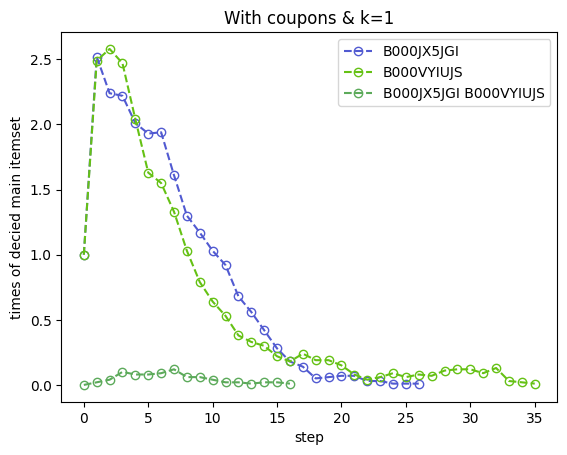

In [39]:
import matplotlib.pyplot as plt

plt.figure("Main Itemset")
for k,v in tagger["TagDecidedMainItemset"].items():
    plt.plot(list(range(len(v))), v, 'ko--', color=colors[k], label=k, markerfacecolor='none')
plt.title("Withput coupons")
plt.xlabel("step")
plt.ylabel("times of decied main itemset")
plt.legend()

In [11]:
str(outputCoupons[0])

'32.31,B000JX5JGI B000VYIUJS,5.0,B000VYIUJS'

### 可累積商品和累積門檻條件的變化對於使用者CP值感知的影響

In [1]:
import pandas as pd

from package.model import DiffusionModel
from package.topic import TopicModel
from package.social_graph import SN_Graph
from package.itemset import ItemsetFlyweight, ItemRelation
from package.utils import getItemsPrice, read_items
from package.algorithm import Algorithm
from package.coupon import Coupon
from package.user_proxy import UsersProxy

NUM_TOPICS = 5
TOPICS = {
    "Node": {
        "0": [0.9, 0.1, 0.0],
        "1": [0.2, 0.8, 0.0],
        "2": [0.8, 0.2, 0.0],
        "3": [0.2, 0.4, 0.4],
    },
    "Item": {
        "iPhone": [0.7, 0.0, 0.3],
        "AirPods": [0.9, 0.0, 0.1],
        "Galaxy": [0.0, 0.8, 0.2],
    }
}
PRICES = {
    "iPhone": 260.0,
    "AirPods": 60.0,
    "Galaxy": 500.0,
}
RELATION = pd.DataFrame.from_dict({
            "iPhone":{
                "AirPods":10,
                "Galaxy":-5
            },
            "AirPods":{
                "iPhone":1,
                "Galaxy":0,
            },
            "Galaxy":{
                "iPhone":-8,
                "AirPods":1,
            }
            })

topicModel = TopicModel(3, TOPICS["Node"], TOPICS["Item"])
relation = ItemRelation(RELATION)
itemset = ItemsetFlyweight(prices = PRICES, topic = topicModel.getItemsTopic(), relation=relation)
graph = SN_Graph(topicModel.getNodesTopic())
coupon = Coupon(500, itemset["Galaxy"], itemset["AirPods iPhone"].price*0.6, itemset["AirPods iPhone"])
user_proxy = UsersProxy(graph, itemset, [coupon], 0)
graph.add_node("0", adopted_set=None, desired_set=itemset["Galaxy"], topic=TOPICS["Node"]["0"])

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

step = 20
# 可累積商品
list_accItemset = [id for id, items in itemset if itemset.issubset(itemset["Galaxy"], items)]

# 累積門檻
list_accThreshold = list(np.arange(itemset["Galaxy"].price, itemset["Galaxy iPhone AirPods"].price+step*10, step))

# 折抵商品
list_disItemset = [id for id, items in itemset]

# 折抵金額
list_discount = list(np.arange(0, itemset["Galaxy iPhone AirPods"].price, step=step))

multi_index = []
data = []
results = [] # for debug

for acc_itemset_id in list_accItemset:
    coupon.accItemset = itemset[acc_itemset_id]

    for threshold in list_accThreshold:
        coupon.accThreshold = threshold

        for dis_itemset_id in list_disItemset:
            coupon.disItemset = itemset[dis_itemset_id]

            for discount in list_discount:
                coupon.discount = discount

                user_proxy.setCoupons([coupon])
                graph._initNode("0")
                graph.nodes["0"]["desired_set"] = itemset["Galaxy"]
            
                result = user_proxy.adopt("0")
                results.append(result)
                
                multi_index.append((acc_itemset_id, threshold, dis_itemset_id, discount))
                data.append([result["VP"], result["amount"], result["tradeOff_items"]])


In [3]:
# create a multiple index dataframe
index = pd.MultiIndex.from_tuples(multi_index, names=('可累積商品', '累積門檻', '折抵商品', '折抵金額'))
df = pd.DataFrame(data=data ,index=index, columns=['VP值', '價格', '購買商品組合'])

In [4]:
pd.set_option('display.max_columns', None)
df = df.reorder_levels(['可累積商品', '累積門檻', '折抵金額', '折抵商品']).sort_index(level=['可累積商品', '累積門檻', '折抵金額', '折抵商品'])

In [ ]:
coupon_test = Coupon(520, itemset["Galaxy iPhone"], 13, itemset["iPhone"])
graph._initNode("0")
print("Main itemset: {0}".format(user_proxy._mainItemsetVP("0", itemset["Galaxy"])))

for id, obj in itemset:
    if itemset.issubset(itemset["Galaxy"], obj):
        VP = user_proxy._addtionallyAdoptVP("0", itemset["Galaxy"], obj, coupon_test)
        print("{0}: {1:.8f}".format(id, VP))

In [ ]:
df.loc[("Galaxy iPhone", 520)]

1. 將折抵商品分為兩組，有無包含主商品
2. 分成兩個角度觀察
    - 可累積商品為同一組，觀察不同折抵商品組合間，在不同折抵金額下隨著累積門檻越高會有什麼變化
    - 反過來觀察可折抵商品一組

In [ ]:
# 折抵商品不包含主商品
main_items = "Galaxy"
dis_items_exclued_main_items = df[~df.index.get_level_values("折抵商品").str.contains("Galaxy")]
print(dis_items_exclued_main_items)

In [10]:
# 可累積商品
index = 0
acc_itemset = list_accItemset[index]
select_acc_itemset = dis_items_exclued_main_items[dis_items_exclued_main_items.index.get_level_values("可累積商品") == acc_itemset]
print(list_accItemset)
print(list_accItemset[index])


['Galaxy', 'Galaxy iPhone', 'AirPods Galaxy', 'AirPods Galaxy iPhone']
Galaxy


In [11]:
colors = ["#242E91", "#91233B", "#23913D", "#ff3399"]
markers = ["o", "v", "s", "p", "x"]

In [8]:
set(select_acc_itemset.index.get_level_values('折抵商品'))

{'AirPods', 'AirPods iPhone', 'iPhone'}

In [ ]:
pd.set_option('display.max_rows', None)

for distItemset_id in set(select_acc_itemset.index.get_level_values('折抵商品')): # 折抵商品組合
    select_dis_itemset = select_acc_itemset[select_acc_itemset.index.get_level_values("折抵商品") == distItemset_id]
    print(select_dis_itemset)
    # for i in range(len(list_discount)): # 折抵金額
    #     select_discount = select_dis_itemset[select_dis_itemset.index.get_level_values("折抵金額") == list_discount[i]]
    #     print(select_discount)

In [ ]:
for distItemset_id in set(select_acc_itemset.index.get_level_values('折抵商品')): # 折抵商品組合
    select_dis_itemset = select_acc_itemset[select_acc_itemset.index.get_level_values("折抵商品") == distItemset_id]
    print(distItemset_id)
    plt.figure("the relation of VP with discount items: {0}".format(distItemset_id))
    for i in range(len(list_discount)): # 折抵金額
        select_discount = select_dis_itemset[select_dis_itemset.index.get_level_values("折抵金額") == list_discount[i]]
        print(list_discount[i])
        plt.plot(list_accThreshold, list(select_discount["VP值"]), 'k' + markers[i] + '--', 
                color=colors[i], 
                label="{:.0f}% off".format(list_discount[i]*100), 
                markerfacecolor='none')
    plt.title("the relation of VP with discount items: {0}".format(distItemset_id))
    plt.xlabel("Threshold of coupon")
    plt.ylabel("VP")
    plt.legend()

    plt.figure("the relation of amount with discount items: {0}".format(distItemset_id))
    for i in range(len(list_discount)): # 折抵金額
        select_discount = select_dis_itemset[select_dis_itemset.index.get_level_values("折抵金額") == list_discount[i]]
        plt.plot(list_accThreshold, list(select_discount["價格"]), 'k' + markers[i] + '--', 
                color=colors[i], 
                label="{:.0f}% off".format(list_discount[i]*100), 
                markerfacecolor='none')
    plt.title("the relation of amount with discount items: {0}".format(distItemset_id))
    plt.xlabel("Threshold of coupon")
    plt.ylabel("VP")
    plt.legend()